In [1]:
import pandas as pd 
import numpy as np
import os 
import yaml
import glob 
import torch
import sys 
from PIL import Image

In [2]:
sys.path.insert(0,"/home/lmeyers/ReID_CNN/SCL_reID/")

from utils.pytorch_data import *
from visualization.vis_utils import show_conf_matrix
from models.pytorch_models import *


/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-23 23:55:40.093685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 23:55:40.973181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings(model, dataloader, loss_fn, miner, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float).to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            hard_pairs = miner(outputs, labels)
            loss += loss_fn(outputs, labels, hard_pairs).detach().cpu().numpy()
            embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    loss/=k
    return embeddings, all_labels#, loss
##########################################################################################



### Load df of Data

In [4]:
df_path = "/home/lmeyers/summer_bee_data_reextract/new_open_max_ids_batch2/summer_bee_dataset_open_train_bee_64_ids_batch2_sample_num_64.csv"
df = pd.read_csv(df_path)
df = df[df.columns.to_list()[7:]]
df.head()

,img_number,ID,color_id,frame,track,batch,pass,environment,bee_range,filepath,background,reID,color_num,new_filepath
0,0,74,blue-blue,19927,171,2,2.0,outside,65-96,/home/gsantiago/summer_bee_data/summer_bee_dat...,blue,74,0,/home/lmeyers/summer_bee_data_reextract/images...
1,1,74,blue-blue,13869,83,2,NaN,in-lab,65-96,/home/gsantiago/summer_bee_data/summer_bee_dat...,blue,74,0,/home/lmeyers/summer_bee_data_reextract/images...
2,2,74,blue-blue,19756,166,2,2.0,outside,65-96,/home/gsantiago/summer_bee_data/summer_bee_dat...,blue,74,0,/home/lmeyers/summer_bee_data_reextract/images...
3,3,74,blue-blue,19933,171,2,2.0,outside,65-96,/home/gsantiago/summer_bee_data/summer_bee_dat...,blue,74,0,/home/lmeyers/summer_bee_data_reextract/images...
4,4,74,blue-blue,14463,83,2,NaN,in-lab,65-96,/home/gsantiago/summer_bee_data/summer_bee_dat...,blue,74,0,/home/lmeyers/summer_bee_data_reextract/images...


In [5]:
df['bg_num'] = df['background'].apply(lambda x: 0 if x == 'blue' else 1)

In [6]:
from train.pytorch_train_and_eval_reid_2 import *
#eval = knn_evaluation(reference_embeddings,reference_labels,test_embeddings,test_labels,3)

finished imports
beginning execution


### Load Model

In [7]:
sys.path.insert(0,"/home/lmeyers/ReID_CNN/SCL_reID/models/")
model_path =  "/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_64/wandb/run-20240401_193949-pzzxex0c/files/64_ids_batch1_sample_num_64.pth"

#model_path = glob.glob("/home/lmeyers/contrastive_learning_new_training/64_ids_batch*_sample_num_64/wandb/*zwl2iiln*/files/*.pth")
model = torch.load(model_path)

os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Found device: {device}')

model.to(device)

Found device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_simple(model, dataloader, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float).to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    return embeddings, all_labels#, loss
##########################################################################################

# Function to load and flatten images
def load_and_flatten_image(image_path):
    image = image_path
    print(image)
    image_data = Image.open(image)
    small_image = image_data.reduce((4))
    flattened = np.array(small_image).flatten()
    return flattened



## Load Dataframes and create Dataloaders

In [9]:
#Sample out the reference set from df
df_gb = df.groupby(["ID"])
df_ref = df_gb.sample(frac=.1,random_state=101)
df_test = df.drop(df_ref.index)
print(len(df_test))
print(len(df_ref))

3641
378


In [10]:
filepath_col = "new_filepath"
label_col = "ID"

In [11]:
#build dataset and dataloader for modified dataframes
ref_dataset = Flowerpatch(df_ref, filepath_col,
                            label_col,[224,224], 'test', .3)
ref_dataloader = DataLoader(ref_dataset, batch_size=64, shuffle=False)

#also build validation dataset
test_dataset = Flowerpatch(df_test, filepath_col,
                            label_col,[224,224], 'test', .3)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Flatten images for control set

In [12]:

# # Apply the function to each image path in the DataFrame and create a list of flattened images
ref_flat = np.array([load_and_flatten_image(image_path) for image_path in df_ref[filepath_col]])
ref_flat_labels = df_ref[label_col]
test_flat = np.array([load_and_flatten_image(image_path) for image_path in df_test[filepath_col]])
test_flat_labels = df_test[label_col]



/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000007.frame002789.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000009.frame002912.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000005.frame002009.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000009.frame003068.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000002.frame001307.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000002.frame000879.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-in-lab-65-96_batch_2.mp4.track000006.frame002002.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96

/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.track000385.frame028334.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.track000391.frame028474.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000366.frame040469.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_1.mp4.track000406.frame029820.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000389.frame042265.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000397.frame043082.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-65-96_batch_2_pass_2.mp4.track000386.frame042033.png
/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outsi

### calculate embeddings 

In [13]:
ref_embeddings, ref_labels = get_embeddings_simple(model,ref_dataloader,device)
test_embeddings, test_labels = get_embeddings_simple(model,test_dataloader,device)

### calculate Control 

Training kNN classifier with k=1


/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1NN test accuracy: 0.27
Training kNN classifier with k=3


/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


3NN test accuracy: 0.1739

Per label 1NN test accuracy:
65	0.12
66	0.47
67	0.29
68	0.16
69	0.34
70	0.07
71	0.38
72	0.34
73	0.10
74	0.51
75	0.17
76	0.74
77	0.21
78	0.17
79	0.31
80	0.16
81	0.07
82	0.24
83	0.17
84	0.21
85	0.16
86	0.05
87	0.14
88	0.22
89	0.16
90	0.19
91	0.17
92	0.10
93	0.14
94	0.26
95	0.00
96	0.09
97	0.10
98	0.24
99	0.22
100	0.09
101	0.00
102	0.12
103	0.17
104	0.29
105	0.16
106	0.02
107	0.03
108	0.31
109	0.02
110	0.16
111	0.14
112	0.36
113	0.00
114	0.00
115	0.12
116	0.12
117	0.26
118	0.00
119	0.26
120	0.03
121	0.00
122	0.00
123	0.02
124	0.09
125	0.28
126	0.48
127	0.00
128	0.03

Printing Confusion Matrix:
[[ 7  2  3 ...  0  0  0]
 [ 0 27  0 ...  0  0  0]
 [ 7  0 17 ...  0  0  0]
 ...
 [ 1  0  0 ... 28  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  2 ...  0  0  2]]


/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

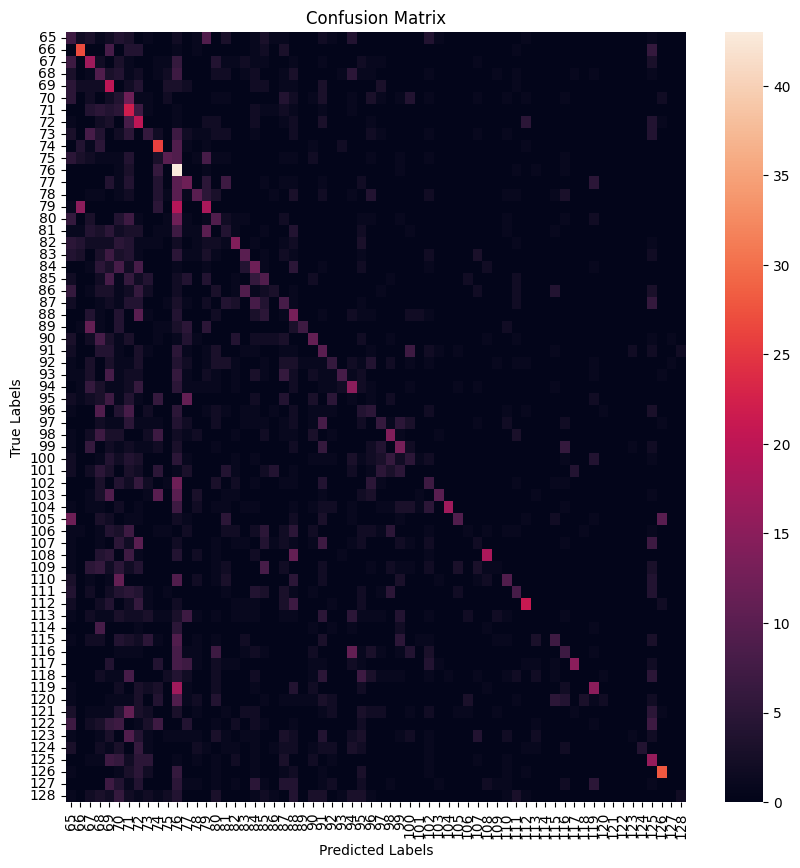

In [14]:
control = knn_evaluation(ref_flat,ref_flat_labels,test_flat,test_flat_labels,1)
show_conf_matrix(control['knn_conf'],ref_flat_labels,test_flat_labels)

Training kNN classifier with k=1
1NN test accuracy: 0.8998
Training kNN classifier with k=3
3NN test accuracy: 0.8893

Per label 1NN test accuracy:
65	0.93
66	0.98
67	0.97
68	0.93
69	0.93
70	0.67
71	0.76
72	0.83
73	0.90
74	0.96
75	0.95
76	1.00
77	1.00
78	0.84
79	0.79
80	0.72
81	0.53
82	0.72
83	0.91
84	0.90
85	0.64
86	0.79
87	0.95
88	1.00
89	0.86
90	0.97
91	0.91
92	0.60
93	0.97
94	0.50
95	0.88
96	0.90
97	1.00
98	0.93
99	0.98
100	1.00
101	0.78
102	0.83
103	0.95
104	0.83
105	0.89
106	1.00
107	1.00
108	0.88
109	1.00
110	0.72
111	1.00
112	0.90
113	0.95
114	0.67
115	0.98
116	1.00
117	1.00
118	0.97
119	0.88
120	0.98
121	0.79
122	0.97
123	0.98
124	0.91
125	0.90
126	1.00
127	1.00
128	0.91

Printing Confusion Matrix:
[[54  1  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0 56 ...  0  0  0]
 ...
 [ 0  0  0 ... 58  0  0]
 [ 0  0  0 ...  0 58  0]
 [ 0  0  0 ...  0  0 53]]


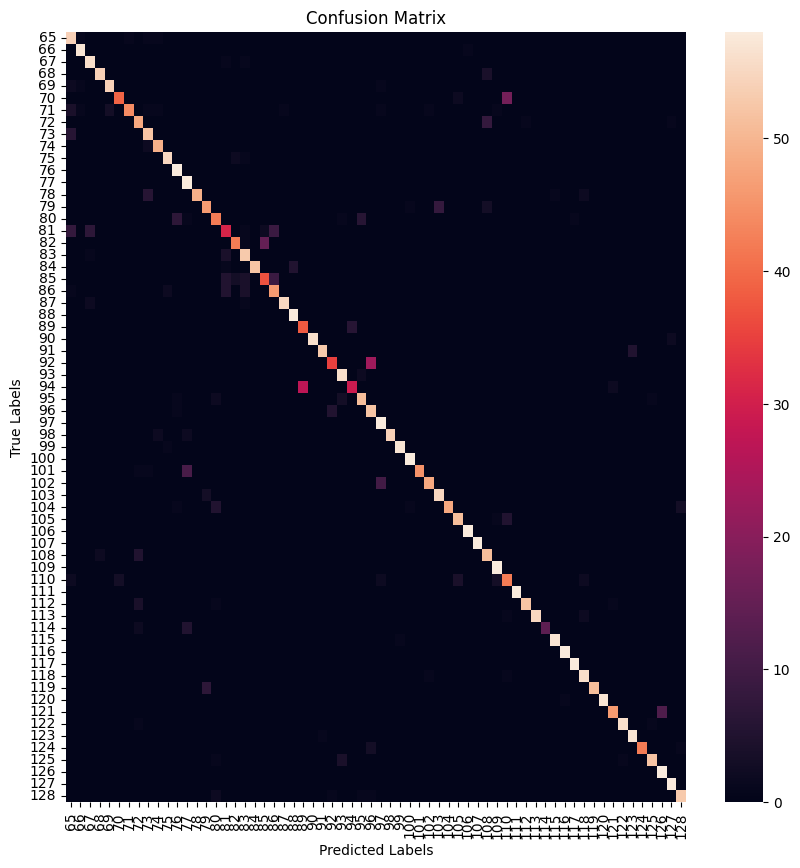

In [15]:
eval = knn_evaluation(ref_embeddings,ref_labels,test_embeddings,test_labels,1)
show_conf_matrix(eval['knn_conf'],ref_labels,test_labels)

In [16]:
import torchvision
from transformers import ViTModel
from transformers import ViTFeatureExtractor, AutoImageProcessor

# print('Getting ViT feature extractor...')
vt_model_name = 'google/vit-base-patch16-224-in21k'
vt_model_path = "/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_64/checkpoints/50.pth"

feature_extractor = AutoImageProcessor.from_pretrained(vt_model_name)


vt_model = ViTModel.from_pretrained(vt_model_name)
vt_model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [17]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_vit(model, dataloader, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float).to(device)
            labels = batch['label'].to(device)
            outputs = model(images)['pooler_output']
            embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    return embeddings, all_labels#, loss
##########################################################################################

In [18]:
#get embeddings from vit model
vt_ref_embeddings, vt_ref_labels = get_embeddings_vit(vt_model,ref_dataloader,device,feature_extractor)
vt_test_embeddings, vt_test_labels = get_embeddings_vit(vt_model,test_dataloader,device,feature_extractor)

Training kNN classifier with k=1
1NN test accuracy: 0.3139
Training kNN classifier with k=3
3NN test accuracy: 0.2161

Per label 1NN test accuracy:
65	0.12
66	0.34
67	0.41
68	0.26
69	0.28
70	0.10
71	0.55
72	0.52
73	0.40
74	0.69
75	0.28
76	0.41
77	0.31
78	0.14
79	0.38
80	0.19
81	0.17
82	0.34
83	0.40
84	0.19
85	0.16
86	0.28
87	0.22
88	0.24
89	0.32
90	0.36
91	0.10
92	0.10
93	0.21
94	0.02
95	0.07
96	0.12
97	0.12
98	0.22
99	0.10
100	0.10
101	0.10
102	0.21
103	0.03
104	0.47
105	0.19
106	0.05
107	0.19
108	0.31
109	0.34
110	0.17
111	0.21
112	0.24
113	0.21
114	0.14
115	0.16
116	0.14
117	0.17
118	0.07
119	0.17
120	0.12
121	0.00
122	0.07
123	0.02
124	0.15
125	0.17
126	0.09
127	0.09
128	0.34

Printing Confusion Matrix:
[[ 7  1  8 ...  0  0  0]
 [ 3 20  0 ...  0  0  0]
 [ 0  0 24 ...  0  0  0]
 ...
 [ 0  0  1 ...  5  0  0]
 [ 0  0  1 ...  0  5  1]
 [ 1  0  0 ...  0  0 20]]


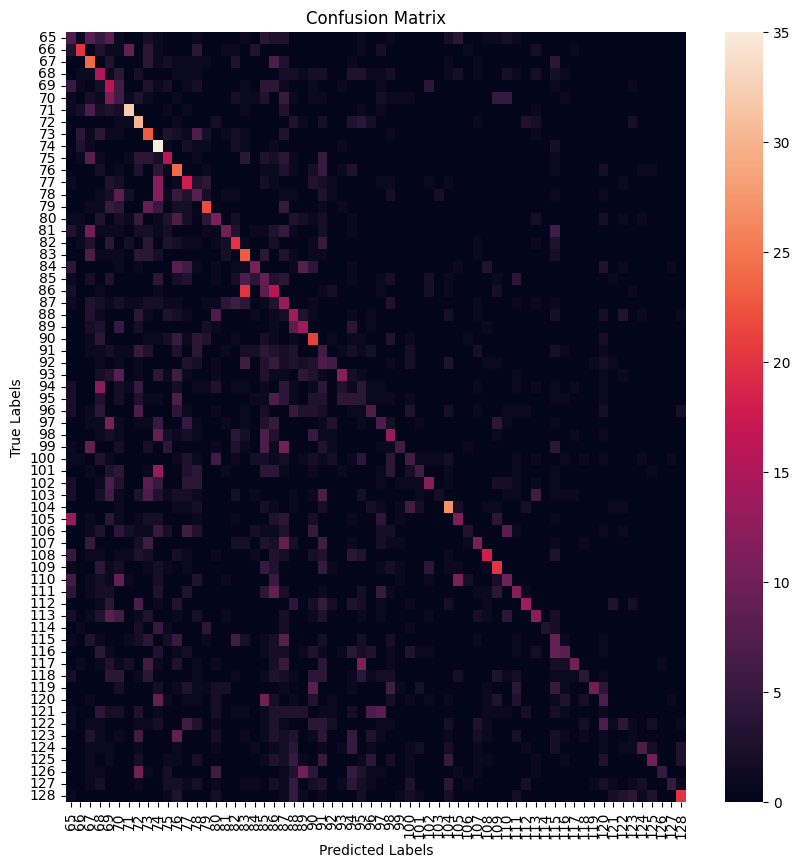

In [19]:
vt_eval = knn_evaluation(vt_ref_embeddings,vt_ref_labels,vt_test_embeddings,vt_test_labels,1)
show_conf_matrix(vt_eval['knn_conf'],vt_ref_labels,vt_test_labels)

## FInetuned VIT

In [20]:
ftvt_model = torch.load("/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_max/wandb/run-20241018_093254-5eva7juu/files/64_ids_batch1_sample_num_max.pth")
ftvt_model.to(device)

ViTForReID(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_feature

In [21]:
#get embeddings from vit model
ft_vt_ref_embeddings, ft_vt_ref_labels = get_embeddings_simple(ftvt_model,ref_dataloader,device,feature_extractor)
ft_vt_test_embeddings, ft_vt_test_labels = get_embeddings_simple(ftvt_model,test_dataloader,device,feature_extractor)

Training kNN classifier with k=1
1NN test accuracy: 0.8506
Training kNN classifier with k=3
3NN test accuracy: 0.8322

Per label 1NN test accuracy:
65	0.88
66	0.95
67	0.90
68	0.84
69	0.79
70	0.88
71	0.72
72	0.79
73	0.86
74	0.80
75	0.90
76	0.98
77	0.57
78	0.69
79	0.95
80	0.83
81	0.97
82	0.97
83	0.91
84	0.78
85	0.98
86	0.83
87	0.93
88	1.00
89	0.82
90	0.83
91	0.88
92	0.95
93	0.79
94	0.40
95	0.95
96	0.78
97	0.95
98	0.74
99	0.66
100	1.00
101	0.79
102	0.98
103	0.97
104	0.91
105	0.51
106	0.98
107	1.00
108	0.81
109	0.95
110	0.72
111	0.74
112	0.93
113	0.86
114	0.43
115	0.90
116	0.91
117	0.50
118	0.90
119	0.86
120	0.55
121	0.72
122	0.88
123	0.97
124	0.48
125	0.78
126	0.78
127	0.78
128	0.90

Printing Confusion Matrix:
[[51  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 52 ...  0  0  0]
 ...
 [ 0  0  0 ... 45  0  0]
 [ 0  0  0 ...  0 45  1]
 [ 0  0  0 ...  0  0 52]]


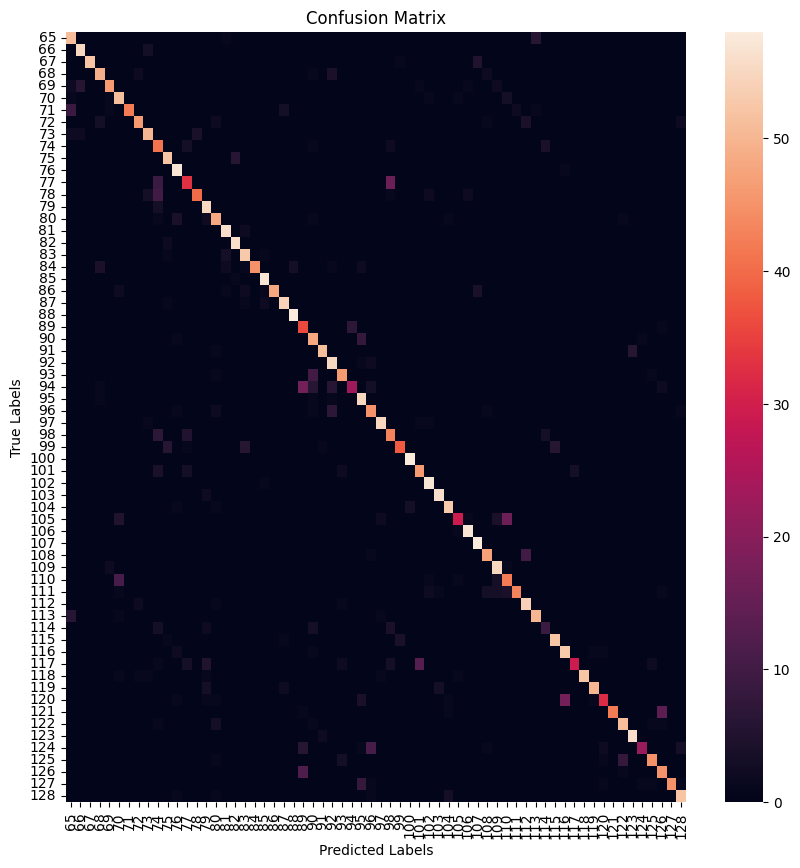

In [22]:
ft_vt_eval = knn_evaluation(ft_vt_ref_embeddings,ft_vt_ref_labels,ft_vt_test_embeddings,ft_vt_test_labels,1)
show_conf_matrix(ft_vt_eval['knn_conf'],ft_vt_ref_labels,ft_vt_test_labels)

## Naive BIOCLIP

In [23]:
import open_clip
from transformers import CLIPFeatureExtractor

clip_flattener = CLIPFeatureExtractor()
bio_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
bio_model.to(device)

/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [24]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_CLIP(model, dataloader, device, feature_extractor=None):
    embeddings = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float).to(device)
            labels = batch['label'].to(device)
            bio_output = model(images)
            vis_out = bio_output[0]
            outputs = vis_out[0]
            embeddings.append(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    all_labels = np.array(all_labels)
    return embeddings, all_labels#, loss
##########################################################################################



In [25]:
print(bio_model.visual.output_dim)

512


In [26]:
bc_ref_embeddings, bc_ref_labels = get_embeddings_CLIP(bio_model,ref_dataloader,device,feature_extractor=clip_flattener)
bc_test_embeddings, bc_test_labels = get_embeddings_CLIP(bio_model,test_dataloader,device,feature_extractor=clip_flattener)


Training kNN classifier with k=1
1NN test accuracy: 0.4773
Training kNN classifier with k=3
3NN test accuracy: 0.3579

Per label 1NN test accuracy:
65	0.31
66	0.45
67	0.26
68	0.55
69	0.28
70	0.31
71	0.47
72	0.62
73	0.41
74	0.67
75	0.48
76	0.59
77	0.53
78	0.19
79	0.29
80	0.60
81	0.26
82	0.47
83	0.47
84	0.48
85	0.09
86	0.29
87	0.40
88	0.52
89	0.73
90	0.52
91	0.36
92	0.34
93	0.21
94	0.19
95	0.19
96	0.36
97	0.47
98	0.41
99	0.16
100	0.19
101	0.17
102	0.31
103	0.66
104	0.60
105	0.26
106	0.16
107	0.41
108	0.38
109	0.24
110	0.17
111	0.31
112	0.40
113	0.17
114	0.00
115	0.29
116	0.17
117	0.38
118	0.09
119	0.38
120	0.29
121	0.21
122	0.29
123	0.43
124	0.30
125	0.55
126	0.48
127	0.33
128	0.24

Printing Confusion Matrix:
[[18  2  9 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 4  2 15 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  2]
 [ 0  0  0 ...  0 19  1]
 [ 0  0  0 ...  3  4 14]]


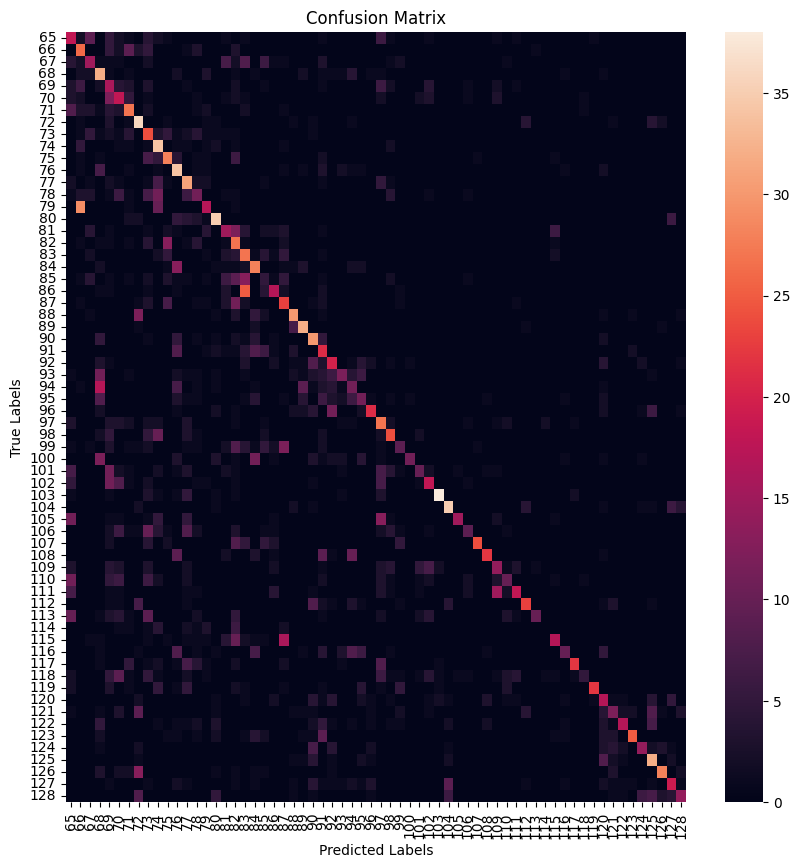

In [27]:
bc_eval = knn_evaluation(bc_ref_embeddings,bc_ref_labels,bc_test_embeddings,bc_test_labels,1)
show_conf_matrix(bc_eval['knn_conf'],bc_ref_labels,bc_test_labels)

## Finetuned BioClip head only

In [28]:

ft_clip = torch.load("/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_max/wandb/run-20241022_121258-rz31k1zl/files/50.pth")


In [29]:
ftbc_ref_embeddings, ftbc_ref_labels = get_embeddings_simple(ft_clip,ref_dataloader,device)
ftbc_test_embeddings, ftbc_test_labels = get_embeddings_simple(ft_clip,test_dataloader,device)

Training kNN classifier with k=1
1NN test accuracy: 0.3785
Training kNN classifier with k=3
3NN test accuracy: 0.3169

Per label 1NN test accuracy:
65	0.36
66	0.36
67	0.55
68	0.47
69	0.22
70	0.36
71	0.47
72	0.60
73	0.34
74	0.75
75	0.50
76	0.28
77	0.36
78	0.24
79	0.28
80	0.62
81	0.21
82	0.45
83	0.28
84	0.76
85	0.26
86	0.19
87	0.40
88	0.69
89	0.77
90	0.36
91	0.33
92	0.41
93	0.24
94	0.17
95	0.31
96	0.40
97	0.33
98	0.41
99	0.10
100	0.14
101	0.05
102	0.17
103	0.05
104	0.48
105	0.18
106	0.17
107	0.53
108	0.38
109	0.34
110	0.26
111	0.19
112	0.28
113	0.14
114	0.10
115	0.14
116	0.14
117	0.17
118	0.09
119	0.26
120	0.19
121	0.09
122	0.16
123	0.16
124	0.33
125	0.45
126	0.57
127	0.19
128	0.10

Printing Confusion Matrix:
[[21  4  0 ...  0  0  0]
 [18 21  0 ...  0  0  0]
 [ 1  1 32 ...  0  0  0]
 ...
 [ 1  0  0 ... 33  0  0]
 [ 0  0  0 ...  3 11  1]
 [ 1  0  0 ...  2  3  6]]


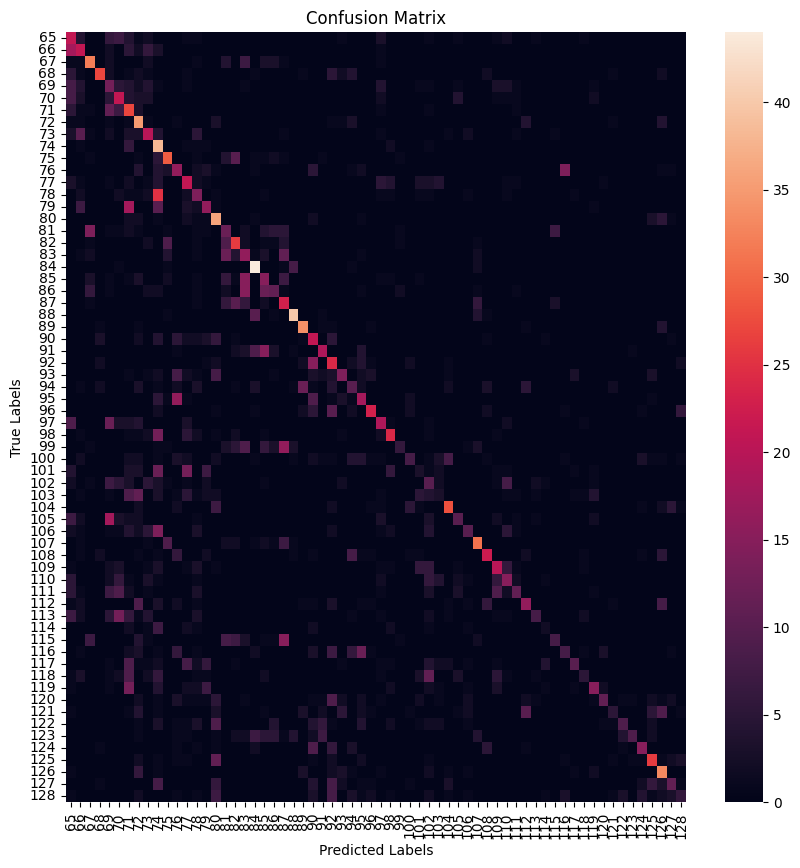

In [30]:
ftbc_eval = knn_evaluation(ftbc_ref_embeddings,ftbc_ref_labels,ftbc_test_embeddings,ftbc_test_labels,1)
show_conf_matrix(ftbc_eval['knn_conf'],ftbc_ref_labels,ftbc_test_labels)

## MultiTask Learner? 

In [35]:
from torch import nn

class IdentityHead(nn.Module):
    def forward(self, x):
        # The forward pass simply returns the input as is
        return x

class ColorDetectHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ColorDetectHead, self).__init__()
        self.fc = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

 
class MultiHeadModel(nn.Module):
    def __init__(self, base_model):
        super(MultiHeadModel, self).__init__()
        self.base_model = base_model
        self.identity_head = IdentityHead()
        self.color_detection_head = ColorDetectHead(128,8)

    def forward(self, x):
        features = self.base_model(x)
        identity_output = self.identity_head(features)
        color_output = self.color_detection_head(features)
        return identity_output, color_output


In [39]:

mt_model = torch.load("/home/lmeyers/ReID_CNN/multi_task_expiraments/summer_MTL_test_250e.pth")
mt_model.to(device)
print(mt_model)

MultiHeadModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [44]:
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_embeddings_multitask(model, dataloader, device, feature_extractor=None):
    embeddings = []
    predictions = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image'].to(device)
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float).to(device)
            labels = batch['label'].to(device)
            features, probs = model(images)
            embeddings.append(features.detach().cpu().numpy())
            predictions.append(probs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    embeddings = np.vstack(embeddings)
    predictions = np.vstack(predictions)
    all_labels = np.array(all_labels)
    return embeddings, predictions, all_labels#, loss
##########################################################################################

In [45]:
mt_ref_embeddings, mt_ref_preds, mt_ref_labels = get_embeddings_multitask(mt_model,ref_dataloader,device)
mt_test_embeddings, mt_test_preds, mt_test_labels = get_embeddings_multitask(mt_model,test_dataloader,device)

Training kNN classifier with k=1
1NN test accuracy: 0.4664
Training kNN classifier with k=3


3NN test accuracy: 0.4823

Per label 1NN test accuracy:
65	0.02
66	0.21
67	0.62
68	0.88
69	0.72
70	0.38
71	0.36
72	0.72
73	0.48
74	0.00
75	0.72
76	0.81
77	0.57
78	0.72
79	0.26
80	0.76
81	0.69
82	0.21
83	0.00
84	0.72
85	0.74
86	0.95
87	0.57
88	0.90
89	0.66
90	0.91
91	0.78
92	0.17
93	0.83
94	0.57
95	0.36
96	0.52
97	0.28
98	0.64
99	0.60
100	0.28
101	0.02
102	0.03
103	0.03
104	0.29
105	0.28
106	0.24
107	0.74
108	0.48
109	0.72
110	0.26
111	0.28
112	0.50
113	0.24
114	0.10
115	0.66
116	0.60
117	0.57
118	0.64
119	0.00
120	0.43
121	0.60
122	0.84
123	0.67
124	0.02
125	0.66
126	0.19
127	0.66
128	0.14

Printing Confusion Matrix:
[[ 1  0  7 ...  0  0  0]
 [ 0 12  1 ...  3  0  0]
 [ 0  0 36 ...  0  0  0]
 ...
 [ 0  2  0 ... 11  0  0]
 [ 0  0  0 ...  0 38  0]
 [ 1  0  2 ...  1  0  8]]


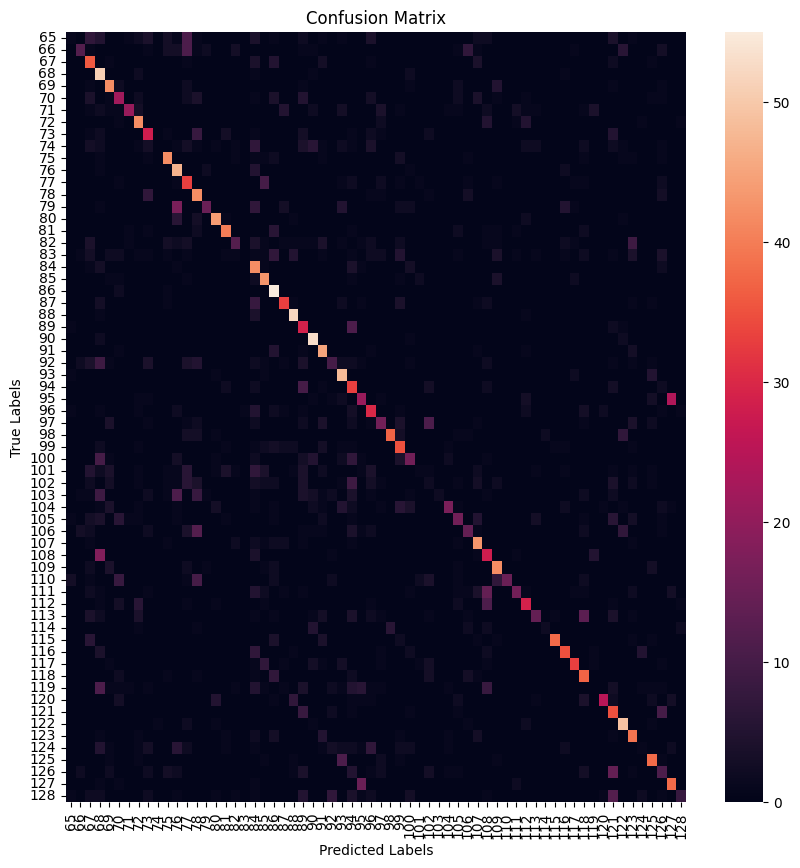

In [47]:
mt_eval = knn_evaluation(mt_ref_embeddings,mt_ref_labels,mt_test_embeddings,mt_test_labels,1)
show_conf_matrix(mt_eval['knn_conf'],mt_ref_labels,mt_test_labels)